In [1]:
from IPython.display import Image

## basics

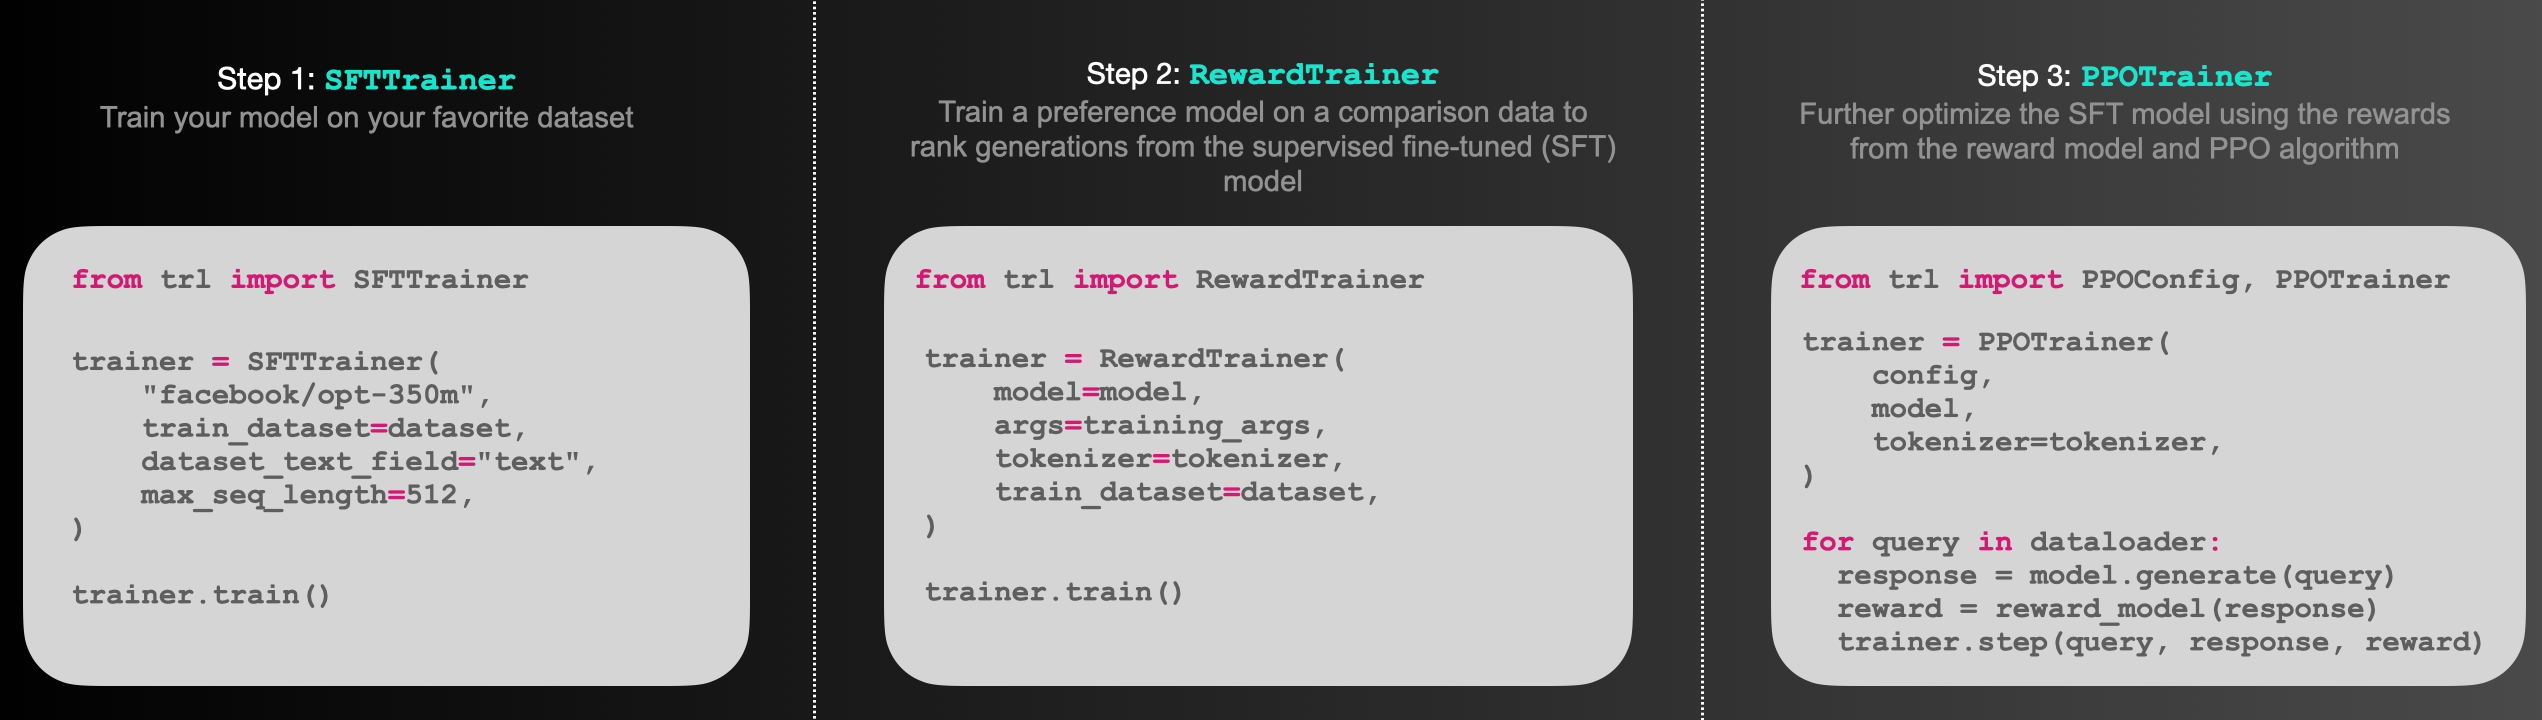

In [23]:
Image('../imgs/trl_steps.png')

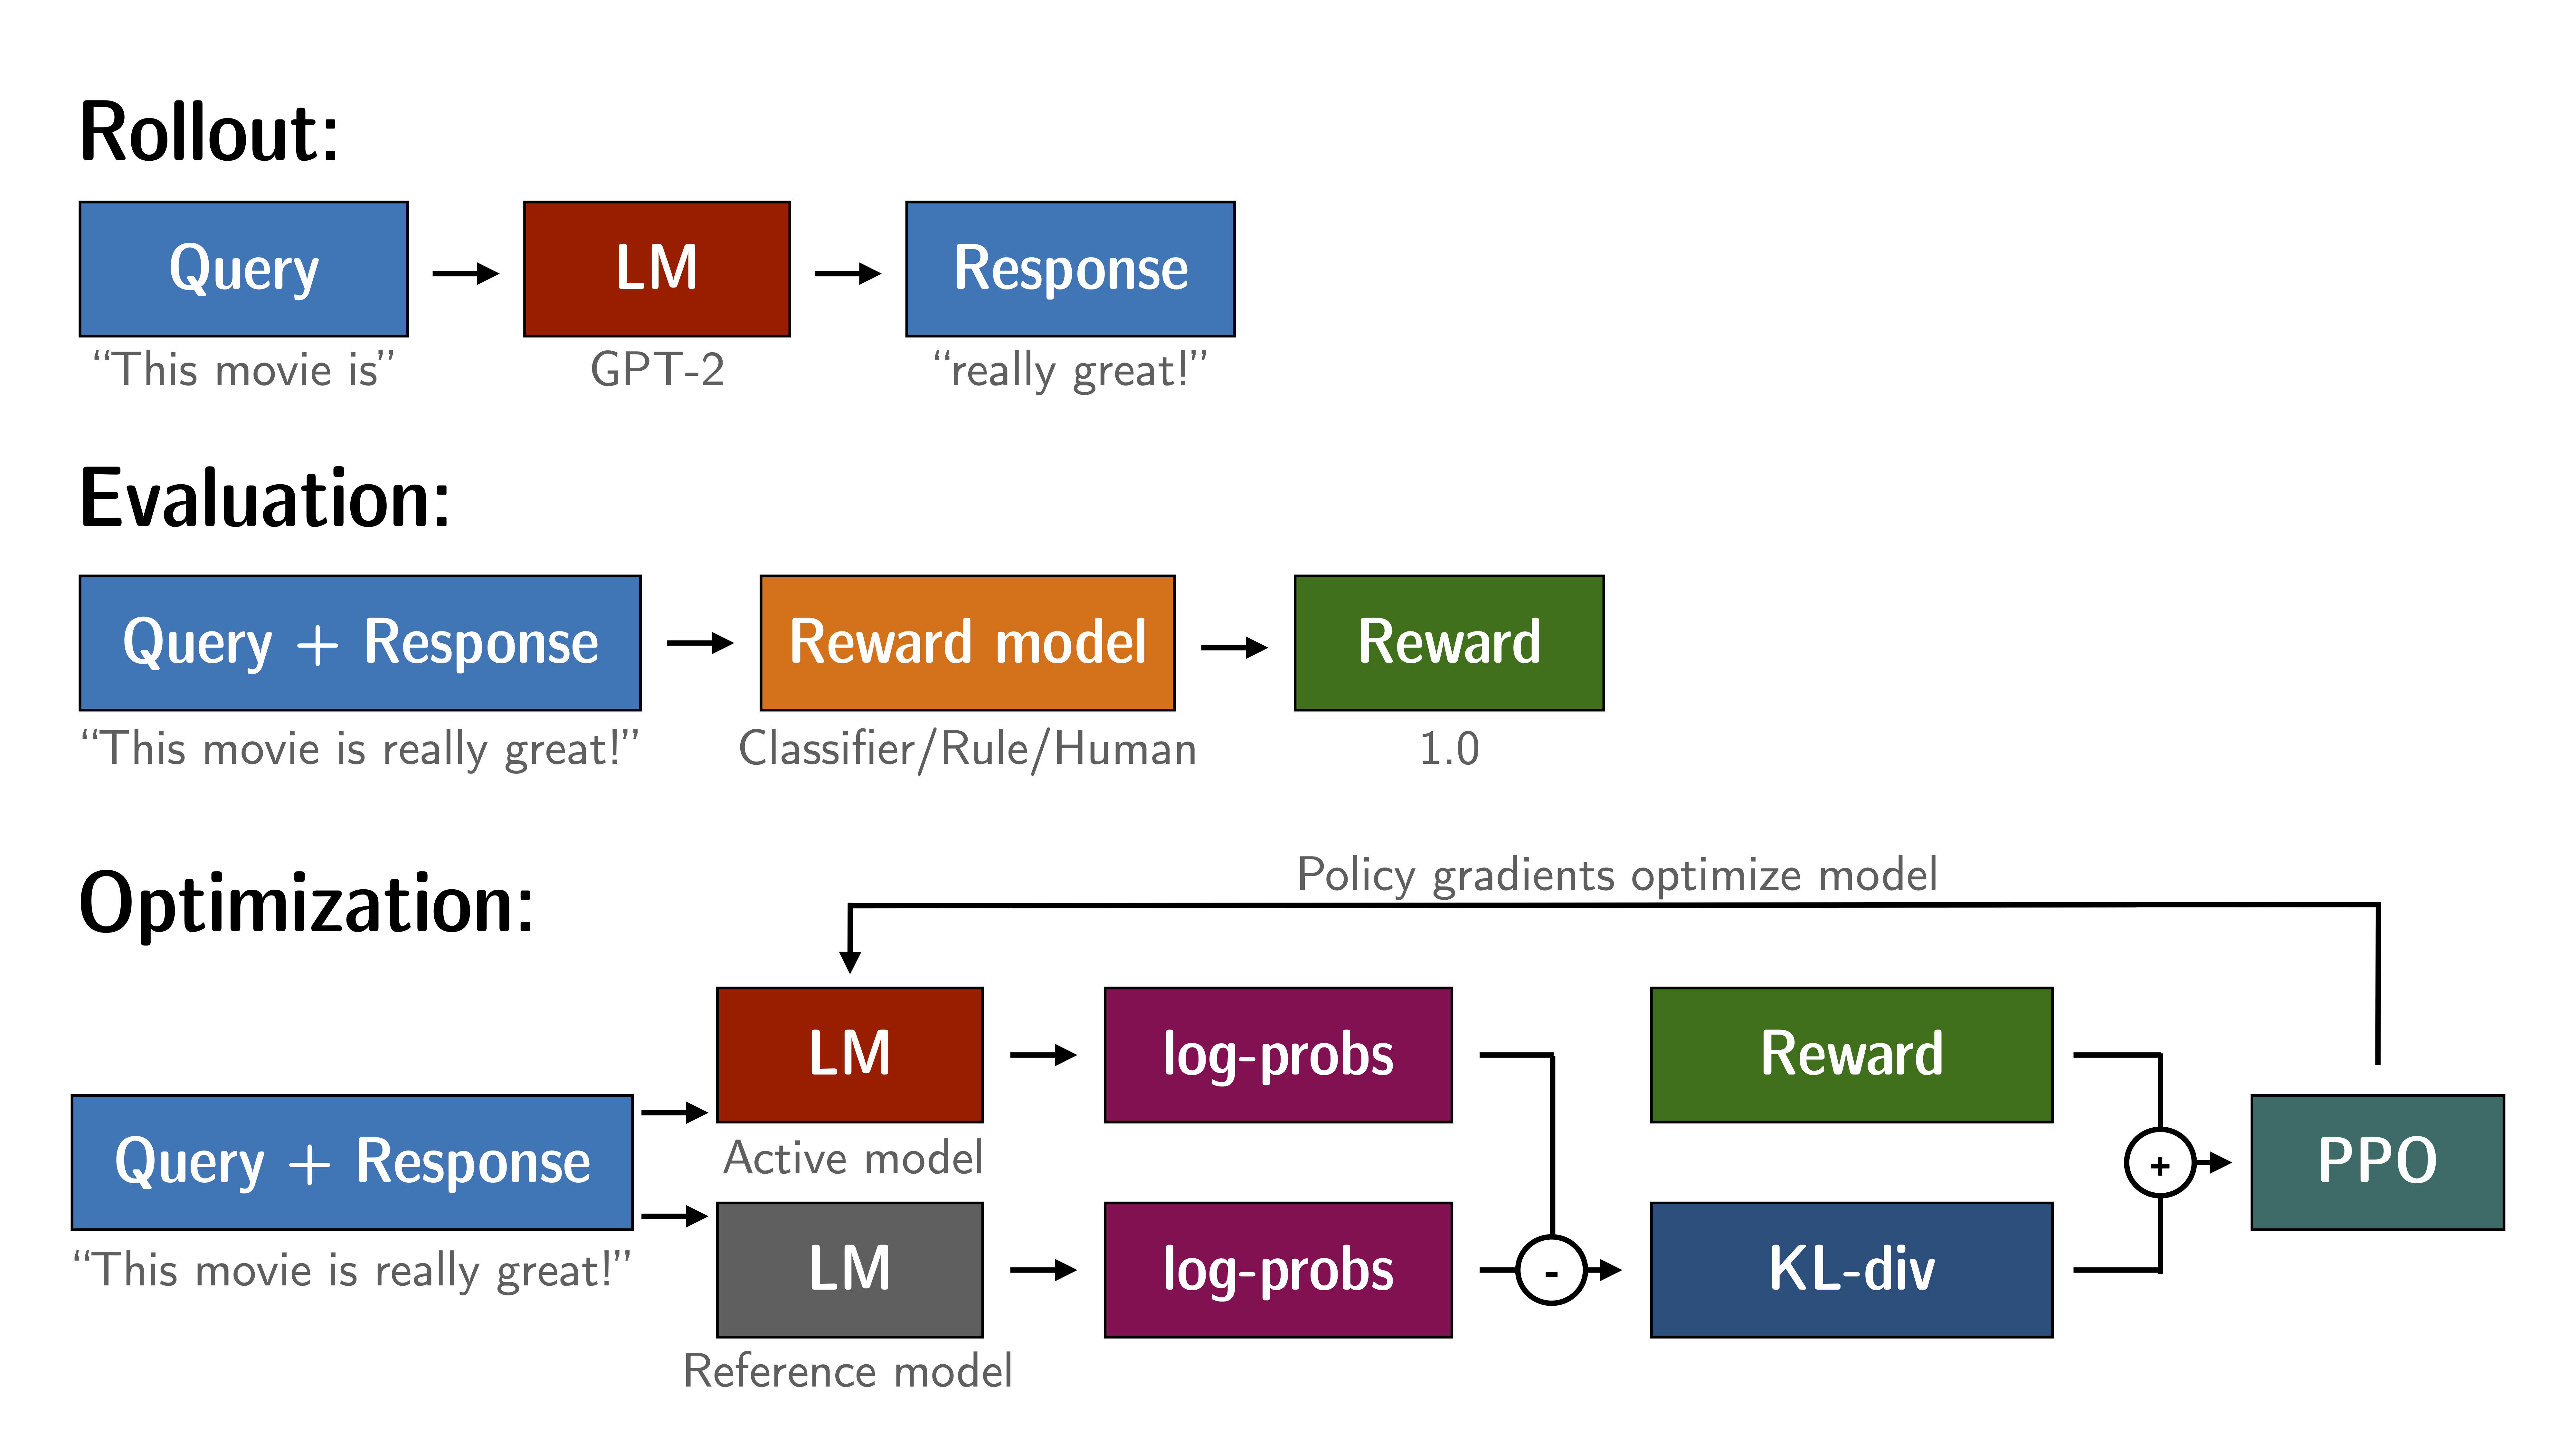

In [24]:
Image('../imgs/trl_pipeline.png')

## examples 与示例代码

```
pip install trl
git clone https://github.com/lvwerra/trl
python trl/examples/scripts/sft_trainer.py \
    --model_name meta-llama/Llama-2-7b-hf \
    --dataset_name timdettmers/openassistant-guanaco \
    --load_in_4bit \
    --use_peft \
    --batch_size 4 \
    --gradient_accumulation_steps 2
```

- 默认情况下
    - optimize：AdamW
    - lr scheduler：linear
        - warm up ratio：0

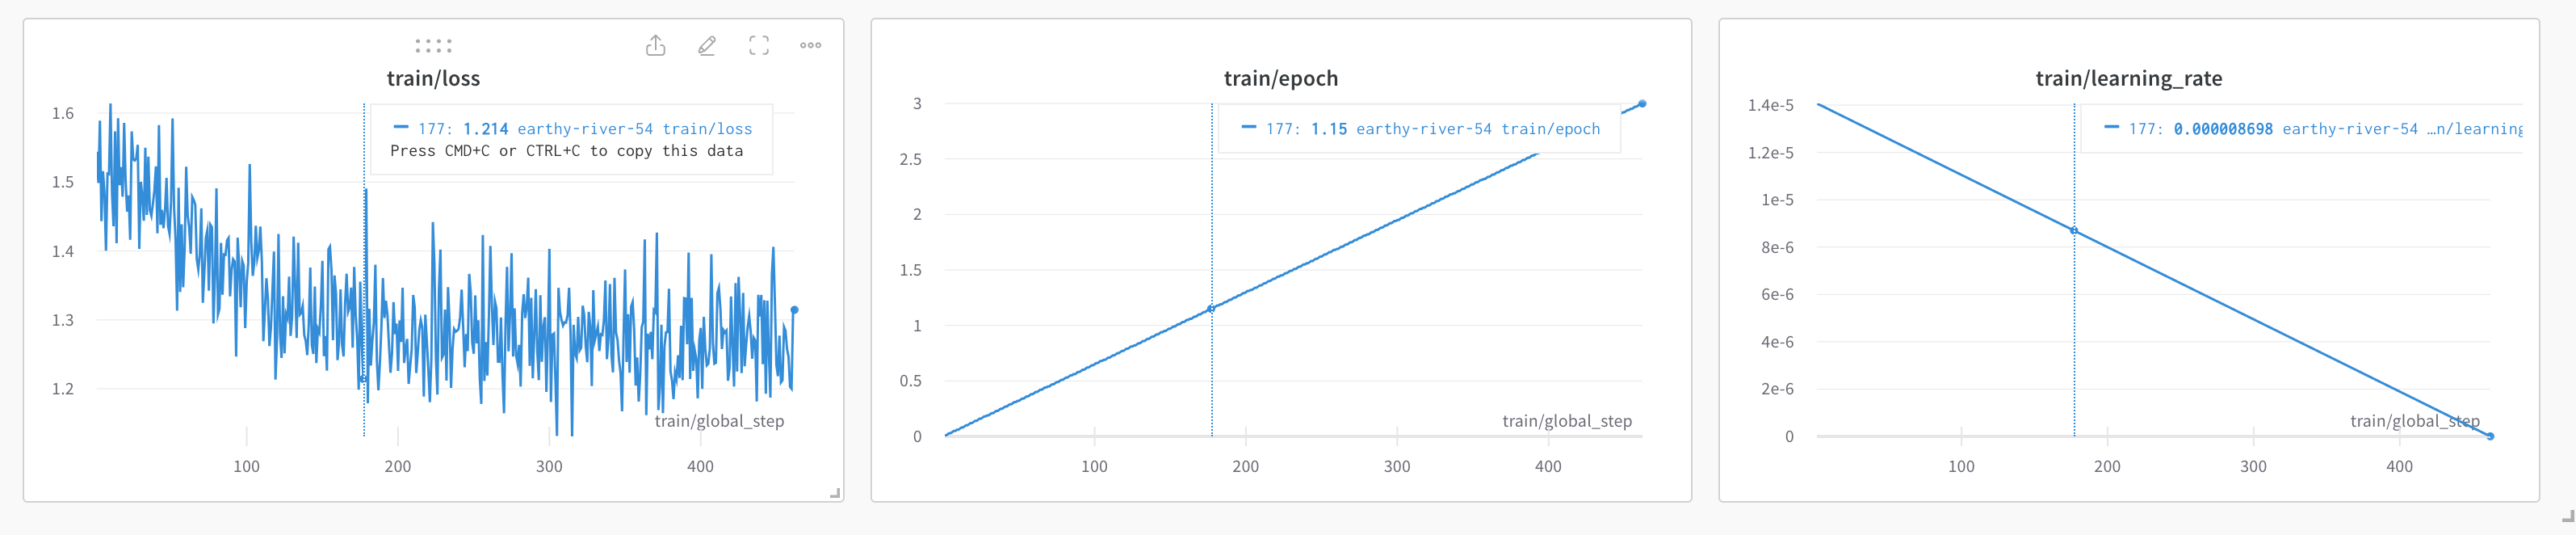

In [2]:
Image('../imgs/trl-sft.png')

## quick start

In [3]:
import torch
from transformers import GPT2Tokenizer
from transformers import AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer

In [2]:
model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
model_ref = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [7]:
casual_lm = AutoModelForCausalLM.from_pretrained('gpt2')
casual_lm

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [8]:
model

AutoModelForCausalLMWithValueHead(
  (pretrained_model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  )
  (

In [9]:
# 2. initialize trainer
ppo_config = {"batch_size": 1}
config = PPOConfig(**ppo_config)
ppo_trainer = PPOTrainer(config, model, model_ref, tokenizer)

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:235: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


In [10]:
model.pretrained_model.device

device(type='cuda', index=0)

In [11]:
query_txt = "This morning I went to the "
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(model.pretrained_model.device)

In [12]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 20,
}

In [18]:
response_tensor = ppo_trainer.generate([item for item in query_tensor], return_prompt=True, **generation_kwargs)

In [19]:
response_txt = tokenizer.decode(response_tensor[0])
response_txt

"This morning I went to the vernacular section to take a class that I've been teaching for Bill for a few decades. Luckily"

In [20]:
# 5. define a reward for response
# (this could be any reward such as human feedback or output from another model)
reward = [torch.tensor(1.0, device=model.pretrained_model.device)]

# 6. train model with ppo
train_stats = ppo_trainer.step([query_tensor[0]], [response_tensor[0]], reward)

In [21]:
train_stats

{'objective/kl': 0.0,
 'objective/kl_dist': 0.0,
 'objective/logprobs': array([[-8.1461258e+00, -2.2490706e+00, -2.6608498e+00, -6.3043290e-01,
         -1.6609859e+00, -9.2277718e+00, -1.5276059e+01, -7.7585630e-02,
         -2.1633016e-02, -4.5973319e-03, -1.2285312e-03, -4.1697159e-02,
         -4.9973121e+00, -7.2619882e+00, -4.5743370e-01, -5.0148611e+00,
         -3.4738617e+00, -4.4298677e+00, -6.5533900e-01, -4.4538689e+00,
         -4.5370131e+00, -1.6291184e+00, -2.8480620e+00, -6.2769735e-01,
         -2.5014224e+00, -9.6736014e-01, -1.2609034e+01, -3.9526312e+00,
         -1.5855569e+00, -1.6140145e+00, -6.2890320e+00, -6.1345702e-01,
         -8.5772448e+00]], dtype=float32),
 'objective/ref_logprobs': array([[-8.1461258e+00, -2.2490706e+00, -2.6608498e+00, -6.3043290e-01,
         -1.6609859e+00, -9.2277718e+00, -1.5276059e+01, -7.7585630e-02,
         -2.1633016e-02, -4.5973319e-03, -1.2285312e-03, -4.1697159e-02,
         -4.9973121e+00, -7.2619882e+00, -4.5743370e-01, 